In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('data/ems_weather.csv')

### **Model Kitchen Sink with Regression Models**

In [ ]:
# NOTE: features[N:M] actually is features[N] through features [M-1] -- it's non-inclusive

# features[0]       --- 'CAD_INCIDENT_ID'                                            ---- DROP (only an index)
# features[1]       --- 'INITIAL_SEVERITY_LEVEL_CODE'
# features[2]       --- 'FINAL_SEVERITY_LEVEL_CODE'
# features[3]       --- 'FIRST_ASSIGNMENT_DATETIME'                                  ---- DROP
# features[4]       --- 'VALID_DISPATCH_RSPNS_TIME_INDC' 
# features[5]       --- 'DISPATCH_RESPONSE_SECONDS_QY'                               ---- DROP
# features[6]       --- 'FIRST_ACTIVATION_DATETIME' 
# features[7]       --- 'VALID_INCIDENT_RSPNS_TIME_INDC'
# features[8]       --- 'INCIDENT_RESPONSE_SECONDS_QY'                               ------> y
# features[9]       --- 'INCIDENT_TRAVEL_TM_SECONDS_QY'
# features[10]      --- 'INCIDENT_CLOSE_DATETIME' 
# features[11]      --- 'HELD_INDICATOR' 
# features[12]      --- 'REOPEN_INDICATOR'
# features[13]      --- 'SPECIAL_EVENT_INDICATOR' 
# features[14]      --- 'STANDBY_INDICATOR'
# features[15]      --- 'TRANSFER_INDICATOR'
# features[16:96]   --- 'INITIAL_CALL_TYPE' dummies
# features[96:186]  --- 'FINAL_CALL_TYPE' dummies
# features[186:195] --- 'INCIDENT_DISPOSITION_CODE' dummies
# features[195:198] --- 'BOROUGH' dummies
# features[198:230] --- 'INCIDENT_DISPATCH_AREA' dummies
# features[230:594] --- 'ZIPCODE' dummies
# features[594:670] --- 'POLICEPRECINCT' dummies
# features[670:720] --- 'CITYCOUNCILDISTRICT' dummies
# features[720:788] --- 'COMMUNITYDISTRICT' dummies
# features[788:819] --- 'COMMUNITYSCHOOLDISTRICT' dummies
# features[829:831] --- 'CONGRESSIONALDISTRICT' dummies
# features[831]     --- 'CALL_YEAR'
# features[832]     --- 'CALL_DAY'
# features[833]     --- 'CALL_TIME'
# features[834]     --- 'CALL_UTC'
# features[835:846] --- 'CALL_MONTH' dummies
# features[846]     --- 'CALL_MONTH' (numeric)
# features[847]     --- 'AWIND'
# features[848]     --- 'PRCP'
# features[849]     --- 'SNOW'
# features[850]     --- 'SNWD'
# features[851]     --- 'TMAX'
# features[852]     --- 'TMIN'
# features[853]     --- 'TAVG_CALC'

In [3]:
features = df.columns

# definitely drop these:
drop_features = ['INCIDENT_RESPONSE_SECONDS_QY', 
                 'CAD_INCIDENT_ID', 
                 'FIRST_ASSIGNMENT_DATETIME', 
                 'DISPATCH_RESPONSE_SECONDS_QY', 'AWND','Unnamed: 0']

# suggest dropping these: 
drop_features += list(features[230:594]) # zip codes
drop_features += list(features[670:831]) # city council district, community district, community school dist, congressional district


X = df.drop(columns=drop_features)

y = df['INCIDENT_RESPONSE_SECONDS_QY']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [10]:
X.columns

Index(['INITIAL_SEVERITY_LEVEL_CODE', 'FINAL_SEVERITY_LEVEL_CODE',
       'VALID_DISPATCH_RSPNS_TIME_INDC', 'FIRST_ACTIVATION_DATETIME',
       'VALID_INCIDENT_RSPNS_TIME_INDC', 'INCIDENT_TRAVEL_TM_SECONDS_QY',
       'INCIDENT_CLOSE_DATETIME', 'HELD_INDICATOR', 'REOPEN_INDICATOR',
       'SPECIAL_EVENT_INDICATOR',
       ...
       'CALL_MONTH_NOV', 'CALL_MONTH_OCT', 'CALL_MONTH_SEP', 'CALL_MONTH',
       'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TAVG_CALC'],
      dtype='object', length=324)

In [4]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [5]:
linreg = LinearRegression()

linreg.fit(X_train_sc, y_train)

print(f'Training: {linreg.score(X_train_sc, y_train)}')
print(f'Testing: {linreg.score(X_test_sc, y_test)}')

Training: 0.8099507237173115
Testing: -5.960625634095039e+23


This does not seem likely, not sure yet why this is the result but there is definitely something not quite right here.

In [6]:
lasso = Lasso(max_iter = 10_000)

lasso.fit(X_train_sc, y_train)

print(f'Training: {lasso.score(X_train_sc, y_train)}')
print(f'Testing: {lasso.score(X_test_sc, y_test)}')

Training: 0.80946832318494
Testing: 0.911510071488905


In [7]:
ridge = Ridge()

ridge.fit(X_train_sc, y_train)

print(f'Training: {ridge.score(X_train_sc, y_train)}')
print(f'Testing: {ridge.score(X_test_sc, y_test)}')

Training: 0.8102790203478583
Testing: 0.9099890960196491


**I realized the issue here.  Left in a lot of data that was used to create our new dependent variable.  This has been corrected more or less.**

### **Lets Try Neural Nets.  The Thinking Persons Artificial Thinker.**

In [8]:
X_train_sc.shape

(15019, 325)

In [9]:
# making no changes, I want the NNet baseline
# Insert model here...
model = Sequential()

model.add(Dense(32, activation = 'relu', input_shape = (325,)))
model.add(Dense(32, activation = 'relu'))

model.add(Dense(1, activation = None))

#compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

# fit the model
results = model.fit(X_train_sc, y_train,
                    batch_size = 100,
                    epochs = 100, 
                    validation_data = (X_test_sc, y_test))



Epoch 1/100
151/151 [==============================] - 2s 8ms/step - loss: 566164.3503 - mae: 524.3283 - val_loss: 467382.3750 - val_mae: 488.8822
Epoch 2/100
151/151 [==============================] - 0s 2ms/step - loss: 461492.2556 - mae: 441.1075 - val_loss: 229478.8125 - val_mae: 271.5674
Epoch 3/100
151/151 [==============================] - 0s 2ms/step - loss: 191594.5875 - mae: 242.6740 - val_loss: 146483.9531 - val_mae: 209.0636
Epoch 4/100
151/151 [==============================] - 0s 2ms/step - loss: 211497.8814 - mae: 203.0741 - val_loss: 117695.0547 - val_mae: 183.7172
Epoch 5/100
151/151 [==============================] - 0s 2ms/step - loss: 147487.9726 - mae: 177.3786 - val_loss: 97114.1094 - val_mae: 163.4306
Epoch 6/100
151/151 [==============================] - 0s 2ms/step - loss: 83346.8348 - mae: 153.3531 - val_loss: 81243.5469 - val_mae: 148.7827
Epoch 7/100
151/151 [==============================] - 0s 2ms/step - loss: 94204.4341 - mae: 143.6828 - val_loss: 69109.5

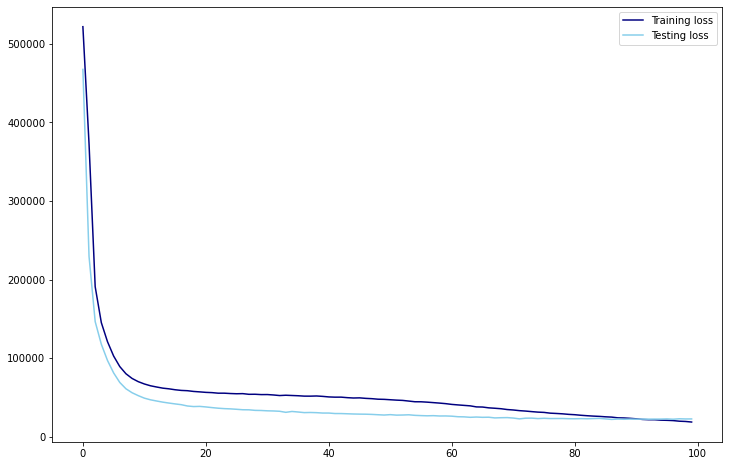

In [10]:
# Visualize the loss
train_loss = results.history['loss']
test_loss =  results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

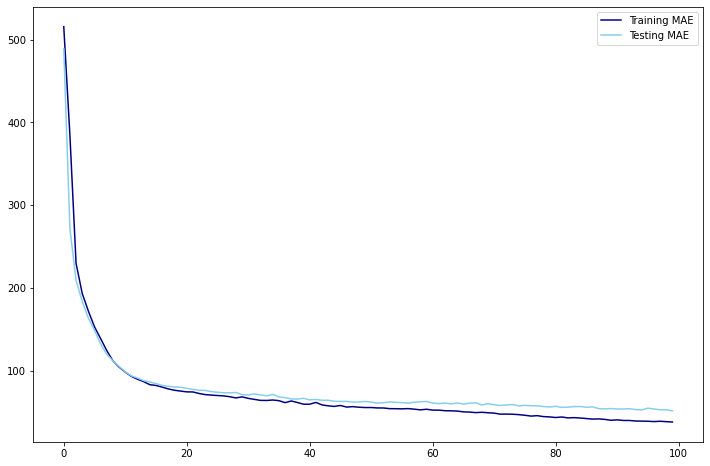

In [11]:
train_mae = results.history['mae']
test_mae =  results.history['val_mae']

plt.figure(figsize=(12, 8))
plt.plot(train_mae, label='Training MAE', color='navy')
plt.plot(test_mae, label='Testing MAE', color='skyblue')
plt.legend();

In [12]:
bag = BaggingRegressor()

bag.fit(X_train_sc, y_train)

print(f'Training: {ridge.score(X_train_sc, y_train)}')
print(f'Testing: {ridge.score(X_test_sc, y_test)}')

Training: 0.8102790203478583
Testing: 0.9099890960196491


# **ALL MODELS BEFORE THIS POINT WERE RUN WITHOUT OUR TRAFFIC DATA**

In [6]:
# the below DF is with scaling

las_coef = pd.read_csv('data/lasso_coefs.csv')

In [8]:
las_coef.sort_values(by ='coefficients', inplace = True)

In [9]:
las_coef

,Unnamed: 0,features,coefficients
253,253,POLICEPRECINCT_46.0,-5.956488
316,316,CALL_MONTH_SEP,-3.338527
116,116,FINAL_CALL_TYPE_DRUG,-1.919331
134,134,FINAL_CALL_TYPE_JUMPUP,-1.663440
74,74,INITIAL_CALL_TYPE_RESPIR,-1.239991
...,...,...,...
118,118,FINAL_CALL_TYPE_EDP,5.272286
189,189,INCIDENT_DISPOSITION_CODE_96.0,6.095546
7,7,HELD_INDICATOR,88.182371
3,3,FIRST_ACTIVATION_DATETIME,193.018453


In [5]:
forest = RandomForestRegressor(n_estimators = 1_000)

forest.fit(X_train_sc, y_train)

print(f'Training: {forest.score(X_train_sc, y_train)}')
print(f'Testing: {forest.score(X_test_sc, y_test)}')

Training: 0.9929484369792958
Testing: 0.9780377543302957


In [20]:
df[['CALL_DAY', 'CALL_YEAR']]

,CALL_DAY,CALL_YEAR
0,1,2011
1,1,2011
2,1,2011
3,1,2011
4,2,2011
...,...,...
20021,2,2021
20022,2,2021
20023,3,2021
20024,3,2021


In [21]:
new_df = pd.read_csv('data/hourlycounts_through2019.csv')

new_df.head()

,Unnamed: 0,year,month,day,hour,num_calls,BRONX,BROOKLYN,MANHATTAN,QUEENS,RICHMOND / STATEN ISLAND,UNKNOWN
0,0,2010,1,1,1,347,60,80,153,45,9,0
1,1,2010,1,1,2,318,75,83,93,58,9,0
2,2,2010,1,1,3,262,63,62,85,45,7,0
3,3,2010,1,1,4,281,63,69,90,52,7,0
4,4,2010,1,1,5,201,55,55,48,39,4,0


In [22]:
X = new_df.drop(columns = 'num_calls')
y = new_df['num_calls']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [23]:
X_train_sc.shape

(65723, 11)

In [24]:
stop = EarlyStopping(monitor = 'mae', patience = 10, min_delta = 1)

# set up structure
model = Sequential()

model.add(Dense(64, activation = 'relu', input_shape = (11,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation = None))

# compile
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

results = model.fit(X_train_sc, y_train, 
          epochs = 100,
          batch_size = 256,
          validation_data = (X_test_sc, y_test),
          callbacks = stop,
                   verbose = 1)

Epoch 1/100
257/257 [==============================] - 1s 2ms/step - loss: 14631.7249 - mae: 97.3552 - val_loss: 939.1160 - val_mae: 19.1941
Epoch 2/100
257/257 [==============================] - 0s 2ms/step - loss: 512.1614 - mae: 16.9767 - val_loss: 375.1443 - val_mae: 11.6659
Epoch 3/100
257/257 [==============================] - 0s 2ms/step - loss: 178.2963 - mae: 9.9063 - val_loss: 92.7955 - val_mae: 5.5379
Epoch 4/100
257/257 [==============================] - 0s 2ms/step - loss: 42.0495 - mae: 4.6253 - val_loss: 31.4336 - val_mae: 2.8366
Epoch 5/100
257/257 [==============================] - 0s 2ms/step - loss: 15.6955 - mae: 2.5651 - val_loss: 13.6606 - val_mae: 1.8927
Epoch 6/100
257/257 [==============================] - 0s 2ms/step - loss: 10.4232 - mae: 1.8108 - val_loss: 7.9241 - val_mae: 1.5336
Epoch 7/100
257/257 [==============================] - 1s 2ms/step - loss: 6.5206 - mae: 1.4315 - val_loss: 5.6381 - val_mae: 1.4678
Epoch 8/100
257/257 [==========================

In [37]:
new_df

,Unnamed: 0,index,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,...,TMAX,TMIN,TAVG_CALC,Borough,County,year,month,day,hour,Incidences
0,0,77,110241339,4,4,19.0,1,19,30.0,1,...,24.0,6.0,15.0,Manhattan,Manhattan,2011,1,24,10,1
1,1,84,110261612,3,3,44.0,1,44,51.0,1,...,35.0,30.0,32.5,Brooklyn,Brooklyn,2011,1,26,11,1
2,2,107,110340066,4,4,14.0,1,14,26.0,1,...,34.0,24.0,29.0,Manhattan,Manhattan,2011,2,3,12,1
3,3,108,110341185,4,4,68.0,1,68,75.0,1,...,34.0,24.0,29.0,Bronx,Bronx,2011,2,3,10,1
4,4,124,110591028,7,7,1575.0,1,1575,1589.0,1,...,60.0,40.0,50.0,Bronx,Bronx,2011,2,28,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,10924,103071018,4,4,397.0,1,397,452.0,1,...,54.0,41.0,47.5,Manhattan,Manhattan,2010,11,3,9,1
1848,1848,10969,103210246,6,6,25.0,1,25,42.0,1,...,60.0,51.0,55.5,Bronx,Bronx,2010,11,17,2,1
1849,1849,10992,103280663,5,5,35.0,1,35,53.0,1,...,50.0,41.0,45.5,Brooklyn,Brooklyn,2010,11,24,7,1
1850,1850,11007,103330127,3,3,15.0,1,15,24.0,1,...,48.0,35.0,41.5,Bronx,Bronx,2010,11,29,1,1


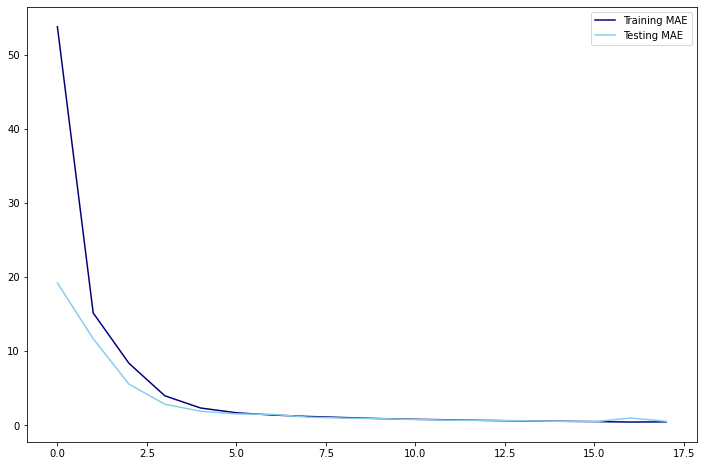

In [26]:
train_mae = results.history['mae']
test_mae =  results.history['val_mae']

plt.figure(figsize=(12, 8))
plt.plot(train_mae, label='Training MAE', color='navy')
plt.plot(test_mae, label='Testing MAE', color='skyblue')
plt.legend();

In [18]:
results.history['mae'][-1]

0.2594188153743744

In [19]:
results.history['mae'][-1]

0.2594188153743744

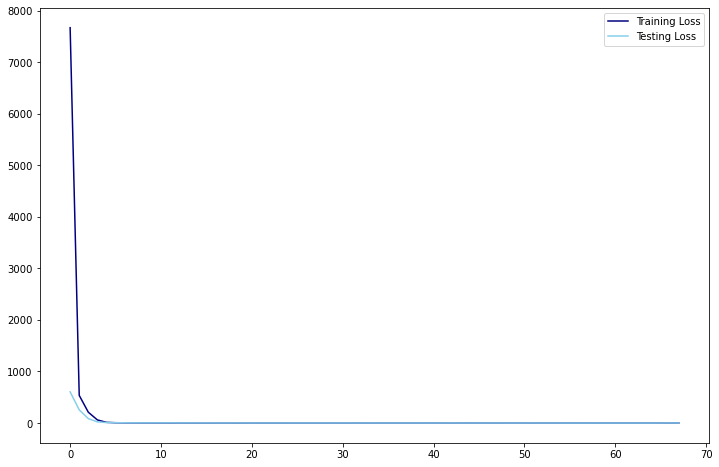

In [20]:
train_mae = results.history['loss']
test_mae =  results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_mae, label='Training Loss', color='navy')
plt.plot(test_mae, label='Testing Loss', color='skyblue')
plt.legend();

In [38]:
new_df = pd.read_csv('data/ems_weather_tfk.csv')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Columns: 864 entries, Unnamed: 0 to Incidences
dtypes: float64(12), int64(850), object(2)
memory usage: 12.2+ MB


In [39]:
X = new_df.drop(columns = ['Brooklyn', ''])
y = new_df['Incidences']

In [ ]:
stop = EarlyStopping(monitor = 'mae', patience = 10, min_delta = .01)

# set up structure
model = Sequential()

model.add(Dense(64, activation = 'relu', input_shape = (863,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation = None))

# compile
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

results = model.fit(X_train_sc, y_train, 
          epochs = 100,
          batch_size = 256,
          validation_data = (X_test_sc, y_test),
          callbacks = stop,
                   verbose = 1)

In [43]:
X.columns

Index(['Unnamed: 0', 'index', 'CAD_INCIDENT_ID', 'INITIAL_SEVERITY_LEVEL_CODE',
       'FINAL_SEVERITY_LEVEL_CODE', 'FIRST_ASSIGNMENT_DATETIME',
       'VALID_DISPATCH_RSPNS_TIME_INDC', 'DISPATCH_RESPONSE_SECONDS_QY',
       'FIRST_ACTIVATION_DATETIME', 'VALID_INCIDENT_RSPNS_TIME_INDC',
       ...
       'SNWD', 'TMAX', 'TMIN', 'TAVG_CALC', 'Borough', 'County', 'year',
       'month', 'day', 'hour'],
      dtype='object', length=863)